In [2]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import random
import pandas as pd
import multiprocessing as mp
import numpy as np
import osmnx as ox
import json
import networkx as nx
import pickle
from data_utils import *
import matplotlib

from scipy.stats import pearsonr, gamma, kstest, ks_2samp
from scipy.stats import ttest_rel, ttest_ind
from scipy.stats import friedmanchisquare
from scipy.stats import shapiro
import matplotlib.pyplot as plt
from acp import *

## Démarche 

### Test students : comparaison score moyen courts / frais
### Trade off distance / fraîcheur
### Caractérisation des segments les plus fréquentés
#### ACP
#### Distribution des proportions / comparaison avec distribution initiale

In [5]:
edges_buffer_scored_path = "output_data/analyse/edges_all_prop.gpkg"
edges_prop = gpd.read_file(edges_buffer_scored_path)
edges_prop.head()

,u,v,key,osmid,oneway,name,highway,maxspeed,reversed,length,...,prairies_prop,ombres_08_prop,ombres_13_prop,ombres_18_prop,arbustes_prop,arbres_prop,C_wavg_scaled,eaux_prop,canop,geometry
0,143403,21714981,0,120412669,False,Rue Professeur Morat,residential,30,False,12.119,...,0.0,0.00,0.0,0.00,0.0,0.60,0.588824,0.0,0.0,"POLYGON ((1846109.564 5172145.602, 1846110.144..."
1,143403,9226919131,0,521119804,True,Avenue Jean Mermoz,primary,50,False,26.832,...,0.0,0.00,0.0,0.00,0.0,0.91,0.588824,0.0,0.0,"POLYGON ((1846084.687 5172144.567, 1846084.135..."
2,143403,9226887756,0,120412669,False,Rue Professeur Morat,residential,30,True,11.073,...,0.0,0.76,0.0,0.00,0.0,0.30,0.588824,0.0,0.0,"POLYGON ((1846122.675 5172142.519, 1846122.463..."
3,143403,10810932922,0,521119804,True,Avenue Jean Mermoz,primary,50,False,15.606,...,0.0,0.36,0.0,0.00,0.0,0.72,0.588824,0.0,0.0,"POLYGON ((1846109.345 5172134.084, 1846108.797..."
4,21714981,9226922647,0,4087154,True,Rue Professeur Morat,unclassified,30,False,8.969,...,0.0,0.00,0.0,0.69,0.0,0.32,0.592353,0.0,0.0,"POLYGON ((1846096.611 5172125.102, 1846096.085..."


In [27]:
final_network_path = "./output_data/network/graph/final_network_all_1.gpkg"
graph = gpd.read_file(final_network_path, layer="edges")

In [28]:
edges_prop = edges_prop.set_index(["uniqId"])
graph = graph.set_index(["uniqId"])

## ALL 1
Tous les poids des variables sont à 1. 

### Test students

In [20]:
def len_if_group(all_it_path):
    all_it = pd.read_csv(all_it_path)

    it_if = all_it[all_it["type"] == "IF"]
    it_len = all_it[all_it["type"] == "LEN"]
    
    return it_if, it_len

def ks_2samp_test(group1, group2, alternative):
    KS, p_value = ks_2samp(group1, group2, alternative=alternative)
    print("KS statistics : ", KS)
    print("p-value : ", p_value)
    return KS, p_value

def test_students(group1, group2, alternative="two-sided"):
    """In order to compare the mean between the distribution of group 1 and group 2"""
    return ttest_rel(group1, group2, alternative=alternative)

def d_cohen(group1, group2):
    """In order to know if there is a size effect"""
    mean1 = np.mean(group1)
    mean2 = np.mean(group2)

    var1 = np.var(group1, ddof=1)
    var2 = np.var(group2, ddof=2)
    
    n1 = len(group1)
    n2 = len(group2)

    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))

    return (mean1 - mean2) / pooled_std

def distance_cost(group1, group2):
    """Calculate the distance cost between itineraries"""
    d1 = np.array(group1["total_length"])
    d2 = np.array(group2["total_length"])

    percent_diff = ((d2-d1)/d1)*100

    return round(np.mean(percent_diff),2)

def select_most_frequent_index(frequency_data, quantile):
    limit_count = frequency_data["count"].quantile([quantile]).iloc[0]
    most_frequent = frequency_data[frequency_data["count"] >= limit_count]
    
    percent = (len(most_frequent)/len(frequency_data))*100
    
    print(f"percent most frequent :", percent)
    
    indexes_most_frequent = most_frequent.index.to_list()
    
    return indexes_most_frequent

def plot_data(data, name, max_y_value):
    # Calculate the common x-axis limits
    min_value = data.min()
    max_value = data.max()

    #Calculate the common y-axis limits
    min_y_value = 0
    max_y_value = max_y_value

    fig1 = plt.figure(figsize=(8, 6))
    plt.hist(data, bins=20, alpha=0.5, color="green")
    plt.xlabel(f"{name}")
    plt.ylabel("Frequency")
    plt.title(f"Histogram - {name}")
    plt.grid(True)
    plt.xlim(min_value, max_value)
    plt.ylim(min_y_value, max_y_value)

    mean = np.mean(data)
    var = np.var(data)
    std = np.std(data)
    quartiles = np.percentile(data, [25, 50, 75])
    sample_size = len(data)

    plt.axvline(mean, color='black', linestyle='dashed', linewidth=1)
    plt.axvline(quartiles[0], color='red', linestyle='dashed', linewidth=1)
    plt.axvline(quartiles[1], color='red', linestyle='solid', linewidth=1)
    plt.axvline(quartiles[2], color='red', linestyle='dashed', linewidth=1)

    plt.text(0.95, 0.95, f"Mean: {mean:.2f}\nVariance: {var:.2f}\nStd Deviation: {std:.2f}\n"
                         f"Q1: {quartiles[0]:.2f}\nQ2: {quartiles[1]:.2f}\nQ3: {quartiles[2]:.2f}\n"
                         f"Sample Size : {sample_size}",
             verticalalignment="top", horizontalalignment="right", transform=plt.gca().transAxes)

    plt.show()


def convert_score_on_ten(x, max):
    return (10/max)*x

def plot_distribution_by_category(dataframe, target_column, category_column, category_colors=None):
    """
    Plot the distribution of a target column colored by a category column.
    
    Parameters:
        dataframe (pd.DataFrame): The DataFrame containing the data.
        target_column (str): The column whose distribution will be plotted.
        category_column (str): The column used for coloring the distribution.
        category_colors (dict, optional): A dictionary specifying the colors for each category. 
                                          If not provided, default colors will be used.
    """
    if category_colors is None:
        category_colors = {}  # Default colors if not provided
        unique_categories = dataframe[category_column].unique()
        default_colors = plt.cm.tab10.colors
        for i, cat in enumerate(unique_categories):
            category_colors[cat] = default_colors[i % len(default_colors)]

    # Extract data for plotting
    data_to_plot = dataframe[[target_column, category_column]]

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot the histograms colored by category
    for cat, group in data_to_plot.groupby(category_column):
        ax1.hist(group[target_column], bins=10, alpha=0.6, color=category_colors[cat], label=cat)
        ax2.hist(group[target_column], bins=10, alpha=0.6, color=category_colors[cat], label=cat)

    # Calculate and display descriptive statistics
    descriptive_stats = dataframe.groupby(category_column)[target_column].describe()
    for cat in descriptive_stats.index:
        mean = descriptive_stats.loc[cat, 'mean']
        variance = descriptive_stats.loc[cat, 'std'] ** 2
        q25 = descriptive_stats.loc[cat, '25%']
        q50 = descriptive_stats.loc[cat, '50%']
        q75 = descriptive_stats.loc[cat, '75%']
        ax2.axvline(mean, color=category_colors[cat], linestyle='dashed', linewidth=1)
        ax2.axvline(q25, color=category_colors[cat], linestyle='dotted', linewidth=1)
        ax2.axvline(q50, color=category_colors[cat], linestyle='dotted', linewidth=1)
        ax2.axvline(q75, color=category_colors[cat], linestyle='dotted', linewidth=1)

    # Set plot properties
    ax1.set_xlabel(target_column)
    ax1.set_ylabel('Frequency')
    ax1.set_title(f'Distribution of {target_column} by {category_column}')
    ax1.legend()

    ax2.set_xlabel(target_column)
    ax2.set_title('Descriptive Statistics')
    ax2.grid(True)

    # Add a legend for descriptive statistics
    legend_elements = [plt.Line2D([0], [0], color=category_colors[cat], lw=1, label=cat) for cat in descriptive_stats.index]
    ax2.legend(handles=legend_elements, title=category_column)

    plt.tight_layout()
    plt.show()

In [41]:
dataset_output_path = "./output_data/analyse/dataset_all_1.gpkg"

In [42]:
dataset_all_1 = gpd.read_file(dataset_output_path)
dataset_all_1 = dataset_all_1.set_index(["uniqId"])

In [142]:
all_it_path = "./output_data/analyse/mean_score_all_1.csv"

it_if, it_len = len_if_group(all_it_path)
print(f"Test de student : {test_students(it_len['score'], it_if['score'], alternative='greater')}")
print(f"D de cohen : {d_cohen(it_len['score'], it_if['score'])}")

print(f"Coût de distance : ", distance_cost(it_len, it_if))

Test de student : TtestResult(statistic=21.150347773690196, pvalue=1.2333466715481158e-87, df=1534)
D de cohen : 0.2459494199902906
Coût de distance :  0.66


Test de student OK mais pas d de cohen => peu d'effet de la fraîcheur

Un coût de distance très négligeable : moins de 1%
La différence entre les deux types d'itinéraires n'est pas flagrante. Logique à priori.

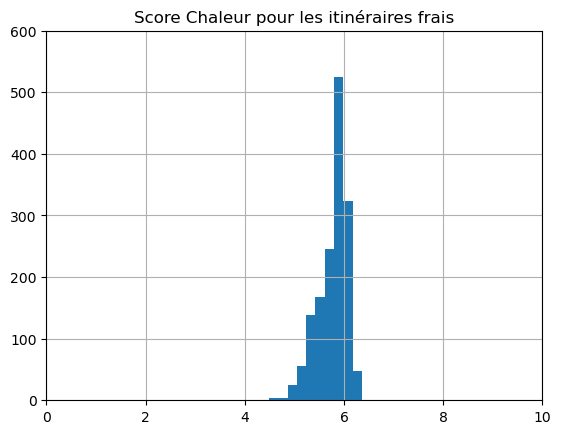

In [4]:
it_if["score"].hist()
plt.xlim([0,10])
plt.ylim([0,600])
plt.title("Score Chaleur pour les itinéraires frais")
plt.show()

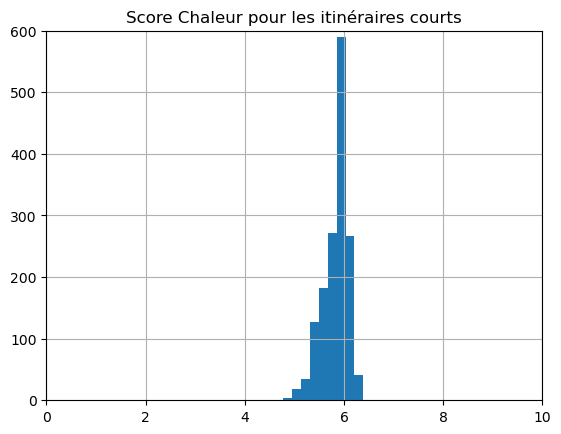

In [37]:
it_len["score"].hist()
plt.xlim([0,10])
plt.ylim([0,600])
plt.title("Score Chaleur pour les itinéraires courts")
plt.show()

Avec des poids à 1 pour chacune des données, on observe clairement la même distribution au niveau des scores.

### Analyse des segments les plus fréquentés

In [18]:
frequency_if_path = "./output_data/analyse/frequency_if_all_1.gpkg"
frequency_len_path = "./output_data/analyse/frequency_len_all_1.gpkg"
frequency_if = gpd.read_file(frequency_if_path)
frequency_len = gpd.read_file(frequency_len_path)

# frequency_if = frequency_if.set_index(["u", "v", "key"])
# frequency_len = frequency_len.set_index(["u", "v", "key"])
frequency_if = frequency_if.set_index(["uniqId"])
frequency_len = frequency_len.set_index(["uniqId"])

In [19]:
frequency_if.columns

Index(['u', 'v', 'key', 'count', 'score_08', 'score_13', 'score_18',
       'geometry'],
      dtype='object')

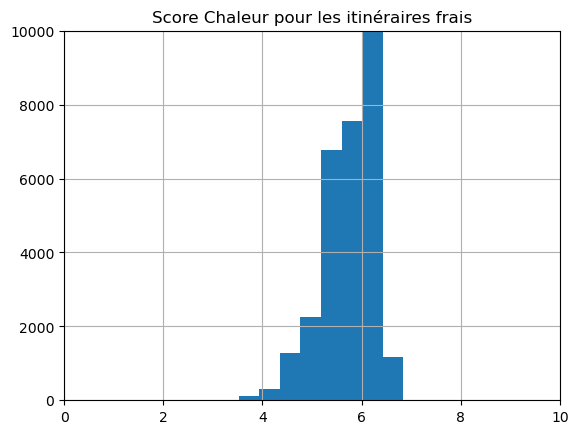

In [20]:
frequency_if["score_08"].hist()
plt.xlim([0,10])
plt.ylim([0,10000])
plt.title("Score Chaleur pour les itinéraires frais")
plt.show()

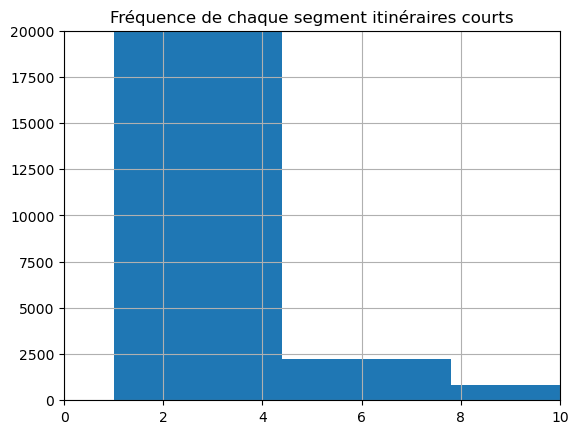

In [38]:
frequency_if["count"].hist()
plt.xlim([0,10])
plt.ylim([0,20000])
plt.title("Fréquence de chaque segment itinéraires courts")
plt.show()

In [21]:
pd.DataFrame(frequency_if["count"]).quantile([0.91]).iloc[0]

count    5.0
Name: 0.91, dtype: float64

Si on regarde la population des 10% segments les plus fréquentés

In [22]:
most_frequent_if = frequency_if[frequency_if["count"] >= 6]

In [23]:
print(len(frequency_if))
print(len(most_frequent_if))

print(round(len(most_frequent_if)/len(frequency_if),2))

29512
2436
0.08


In [24]:
frequency_if.head()

,u,v,key,count,score_08,score_13,score_18,geometry
uniqId,,,,,,,,
14340392268877560,143403,9226887756,0,1,5.351,6.111,6.111,"LINESTRING (4.87762 45.73390, 4.87761 45.73387..."
143403108109329220,143403,10810932922,0,1,5.331,5.691,5.691,"LINESTRING (4.87772 45.73377, 4.87754 45.73383)"
143408217149800,143408,21714980,0,1,6.261,5.981,6.261,"LINESTRING (4.87633 45.73413, 4.87634 45.73421)"
14341283608074510,143412,8360807451,0,2,6.352,6.012,5.512,"LINESTRING (4.86282 45.73848, 4.86286 45.73847)"
14341283608074610,143412,8360807461,0,6,6.352,5.662,5.572,"LINESTRING (4.86272 45.73851, 4.86282 45.73848)"


In [31]:
most_frequent_if_index = select_most_frequent_index(frequency_if, 0.9)
print(most_frequent_if_index)

most_frequent_if = frequency_if.loc[most_frequent_if_index]

percent most frequent : 11.737598265112496
['14341283608074610', '14341333877822070', '1952414122856580', '195250253374570', '19525012712971780', '195251240098410', '195251260593020', '195251260593030', '19525220928536580', '195253260586510', '19525320864025410', '19525687848190190', '19526126514355430', '19526161422855830', '19527634161962530', '19528220864025270', '58167863470654040', '739391473944770', '739447774531632430', '739491073949250', '7394910331492200', '739491073949250', '739492582075060', '739492521156773180', '808905992603684660', '808906251716328250', '820670013746387190', '137463871982071990', '820719974537450600', '820749324721235140', '820749333026226150', '739492582075060', '820750624721235140', '843366230880036650', '843366263667053150', '8433684331952040', '8433684331952080', '494237462084338080', '84340314922619780', '859156850164364510', '859243792494170', '85932794921502640', '859342515815851260', '869825688830290', '870268246746992940', '87039972657835270', '2

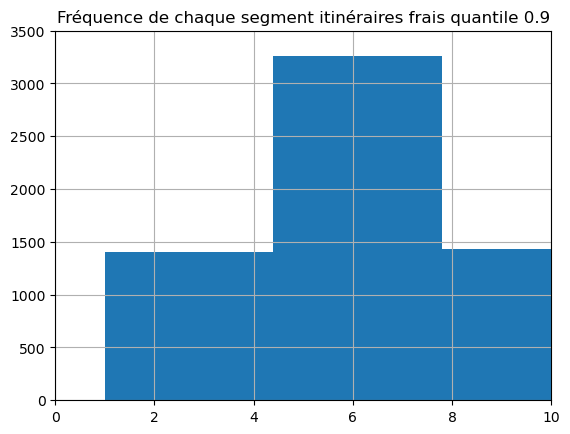

In [35]:
most_frequent_if["count"].hist()
plt.xlim([0,10])
plt.ylim([0,3500])
plt.title("Fréquence de chaque segment itinéraires frais quantile 0.9")
plt.show()

In [29]:
edges_prop_most_frequent_if = edges_prop.loc[most_frequent_if_index]

In [36]:
edges_prop_most_frequent_if.columns

Index(['u', 'v', 'key', 'osmid', 'oneway', 'name', 'highway', 'maxspeed',
       'reversed', 'length', 'from', 'to', 'lanes', 'width', 'service',
       'access', 'bridge', 'ref', 'junction', 'tunnel', 'est_width', 'area',
       'prairies_prop', 'ombres_08_prop', 'ombres_13_prop', 'ombres_18_prop',
       'arbustes_prop', 'arbres_prop', 'C_wavg_scaled', 'eaux_prop', 'canop',
       'geometry'],
      dtype='object')

#### Comparaison distribution Most frequent VS all + test de student

##### Arbres

In [4]:
dataset_all_1_arbres = edges_prop.loc[dataset_all_1.index.unique().to_list()]["arbres_prop"]

print(len(dataset_all_1_arbres))
print(len(edges_prop))

plot_data(dataset_all_1_arbres, "All Arbres", 10000)

NameError: name 'edges_prop' is not defined

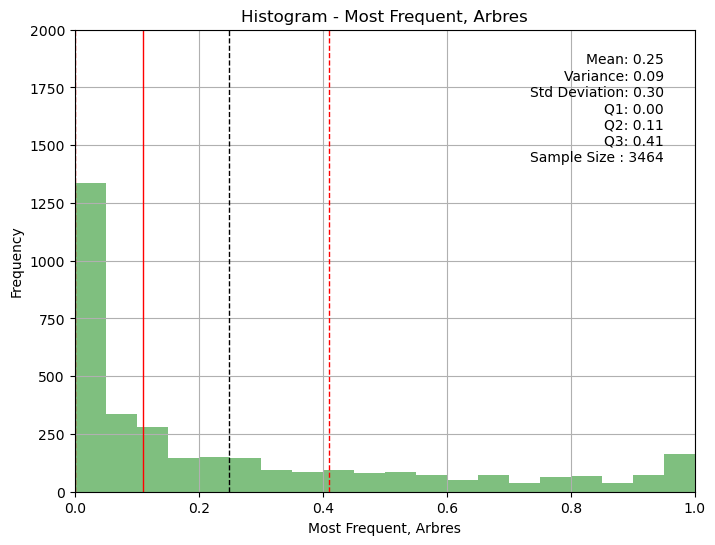

In [52]:
edges_prop_most_frequent_if_arbres = edges_prop_most_frequent_if["arbres_prop"]

plot_data(edges_prop_most_frequent_if_arbres, "Most Frequent, Arbres", 2000)

In [58]:
dataset_all_1_arbres_sample_index = random.sample(dataset_all_1_arbres.index.to_list(), len(edges_prop_most_frequent_if_arbres))
dataset_all_1_arbres_sample = dataset_all_1_arbres.loc[dataset_all_1_arbres_sample_index]

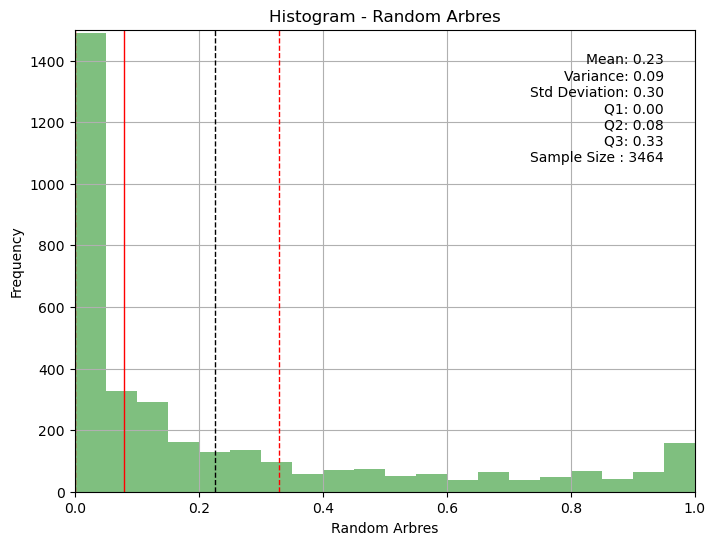

In [59]:
plot_data(dataset_all_1_arbres_sample, "Random Arbres", 1500)

Test de student pour comparer la moyenne de proportion entre des segment pris au hasard et les segments les plus fréquentés.
Le test de student n'est certainement pas adapté, puisque les données ne suivent pas une loi normale. Donc on utilise plutôt un test de Kolmogorov-Smirnov afin de comparer deux échantillons indépendants pour voir s'ils suivent la même loi de distribution ou non.

In [88]:
from scipy.stats import ks_2samp

KS, p_value = ks_2samp(dataset_all_1_arbres_sample, edges_prop_most_frequent_if_arbres, alternative="two-sided")

print("KS statistic : ", KS)
print("p-value : ", p_value)

KS statistic :  0.049653579676674366
p-value :  0.0003899284820930803


H0: The null hypothesis is that the two distributions are identical, F(x)=G(x) for all x; the alternative is that they are not identical.
Donc les données n'ont déjà pas la même distribution car on rejette H0 avec une p_value < au seuil de 5%.

In [84]:
d_cohen(dataset_all_1_arbres_sample, edges_prop_most_frequent_if_arbres)

-0.07764877736544419

Taille d'effet faible

#### Quel type de distribution pour les proportions en arbres : 

A priori pas trouvé => on fait un test ks permettant de comparer deux distributions d'échantillons indépendants. 

In [77]:
from scipy.stats import norm, gamma, expon, poisson, binom, bernoulli, weibull_min, lognorm, pareto, gumbel_r, cauchy, t

In [65]:
def is_gamma(data):
    shape, loc, scale = gamma.fit(data)

    D, p_value = kstest(data, "gamma", args=(shape, loc, scale))

    print(p_value)

In [78]:
def is_pareto(data):
    params = pareto.fit(data)

    D, p_value = kstest(data, "pareto", args=(params))

    print(p_value)

In [ ]:
def is_log_normal(data):
    params = lognorm.fit(data)

    D, p_value = kstest

In [81]:
is_gamma(edges_prop_most_frequent_if_arbres)

9.720896723394896e-225


In [80]:
is_pareto(edges_prop_most_frequent_if_arbres)

1.041747288269352e-204


#### ACP pour comparer l'importance des variables dans la description des individus (segments)

In [91]:
dataset_all_1_prop = edges_prop.loc[random.sample(dataset_all_1.index.unique().to_list(), len(edges_prop_most_frequent_if_arbres))]
print(dataset_all_1_prop.columns)

Index(['u', 'v', 'key', 'osmid', 'oneway', 'name', 'highway', 'maxspeed',
       'reversed', 'length', 'from', 'to', 'lanes', 'width', 'service',
       'access', 'bridge', 'ref', 'junction', 'tunnel', 'est_width', 'area',
       'prairies_prop', 'ombres_08_prop', 'ombres_13_prop', 'ombres_18_prop',
       'arbustes_prop', 'arbres_prop', 'C_wavg_scaled', 'eaux_prop', 'canop',
       'geometry'],
      dtype='object')


In [125]:
features = ['prairies_prop', 'ombres_13_prop','arbustes_prop', 'arbres_prop', 'C_wavg_scaled', 'eaux_prop', 'canop']

In [112]:
def eigein_values(pca, plot=False):
    eig = pd.DataFrame(
        {
            "Dimension" : ["Dim" + str(x + 1) for x in range(len(pca.explained_variance_))], 
            "Variance expliquée" : pca.explained_variance_,
            "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
            "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
        }
    )

    if(plot):
        eig.plot.bar(x = "Dimension", y = "% variance expliquée") # permet un diagramme en barres
        plt.text(5, 18, "17%") # ajout de texte
        plt.axhline(y = 17, linewidth = .5, color = "dimgray", linestyle = "--") # ligne 17 = 100 / 6 (nb dimensions)
        plt.show()

    print(eig)
    return eig

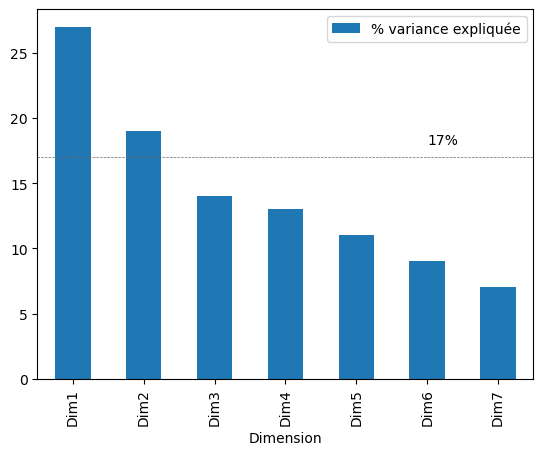

  Dimension  Variance expliquée  % variance expliquée  % cum. var. expliquée
0      Dim1            1.916905                  27.0                   27.0
1      Dim2            1.322804                  19.0                   46.0
2      Dim3            1.001958                  14.0                   61.0
3      Dim4            0.902707                  13.0                   73.0
4      Dim5            0.785241                  11.0                   85.0
5      Dim6            0.595695                   9.0                   93.0
6      Dim7            0.476712                   7.0                  100.0


In [126]:
prop_all_1_pca = pca_pipeline(dataset_all_1_prop, features, 7)
eig_prop_all_1_pca = eigein_values(prop_all_1_pca, plot=True)
coord = coord_pca(dataset_all_1_prop[features], prop_all_1_pca)

In [127]:
plot_ind_pca(dataset_all_1_prop[features], prop_all_1_pca, nbre_dim=3)

               id     COR_1     COR_2
0   prairies_prop  0.561434 -0.559856
1  ombres_13_prop -0.434537  0.210705
2   arbustes_prop  0.492966 -0.590122
3     arbres_prop  0.446522  0.454000
4   C_wavg_scaled -0.762390 -0.205362
5       eaux_prop  0.410352  0.562480
6           canop  0.469358  0.227308


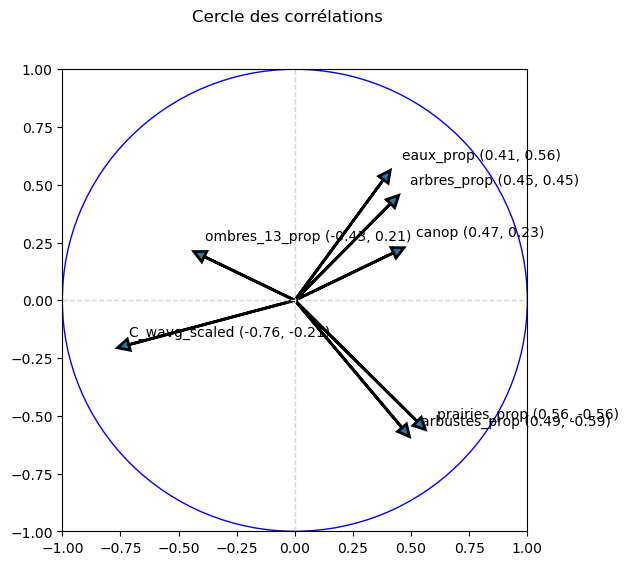

In [128]:
print(coord_var_pca(dataset_all_1_prop[features], prop_all_1_pca, dim=[1,2]))
plot_var_circle(coord_var_pca(dataset_all_1_prop[features], prop_all_1_pca, dim=[1,2]))

Température anti corrélée notamment à la première dimension
Prairies et arbustes anticorrélée avec deuxième et corrélée avec première dimension

               id     COR_1     COR_2
0   prairies_prop  0.561434  0.198326
1  ombres_13_prop -0.434537 -0.233415
2   arbustes_prop  0.492966 -0.352432
3     arbres_prop  0.446522 -0.571023
4   C_wavg_scaled -0.762390  0.103089
5       eaux_prop  0.410352  0.247460
6           canop  0.469358  0.411168


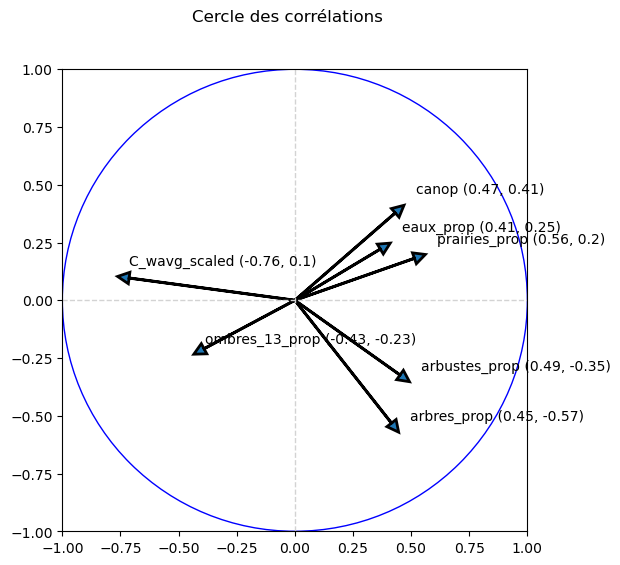

In [129]:
print(coord_var_pca(dataset_all_1_prop[features], prop_all_1_pca, dim=[1,5]))
plot_var_circle(coord_var_pca(dataset_all_1_prop[features], prop_all_1_pca, dim=[1,5]))

ACP sur les segments les plus fréquentés afin de les caractériser en fonctions des variables

In [ ]:
prop_all_1_pca = pca_pipeline(dataset_all_1_prop, features, 7)
eig_prop_all_1_pca = eigein_values(prop_all_1_pca, plot=True)
coord = coord_pca(dataset_all_1_prop[features], prop_all_1_pca)

## Analyse avec les poids : P1O8At2Ar10C6E7Ca8
Prairie : 1
Ombre : 8
Arbustes : 2
Arbres : 10
Température : 6
Eau : 7
Canop : 8

In [130]:
data_set_P1O8At2Ar10C6E7Ca8_path = "./output_data/analyse/P1O8At2Ar10C6E7Ca8/dataset_P1O8At2Ar10C6E7Ca8.gpkg"
data_set_P1O8At2Ar10C6E7Ca8 = gpd.read_file(data_set_P1O8At2Ar10C6E7Ca8_path)

data_set_P1O8At2Ar10C6E7Ca8 = data_set_P1O8At2Ar10C6E7Ca8.set_index(["uniqId"])

In [160]:
graph_P1O8At2Ar10C6E7Ca8_path = "./output_data/network/graph/final_network_P1O8At2Ar10C6E7Ca8.gpkg"
graph_P1O8At2Ar10C6E7Ca8 = gpd.read_file(graph_P1O8At2Ar10C6E7Ca8_path, layer="edges")
print(graph_P1O8At2Ar10C6E7Ca8.columns)
graph_P1O8At2Ar10C6E7Ca8 = graph_P1O8At2Ar10C6E7Ca8.set_index(["uniqId"])

graph_P1O8At2Ar10C6E7Ca8_sample = graph_P1O8At2Ar10C6E7Ca8.loc[data_set_P1O8At2Ar10C6E7Ca8.index.unique().to_list()]

Index(['u', 'v', 'key', 'osmid', 'oneway', 'name', 'highway', 'maxspeed',
       'reversed', 'length', 'from', 'to', 'lanes', 'width', 'service',
       'access', 'bridge', 'ref', 'junction', 'tunnel', 'est_width', 'area',
       'uniqId', 'total_score_08', 'total_score_13', 'total_score_18',
       'score_distance_08', 'score_distance_13', 'score_distance_18',
       'freshness_score', 'geometry'],
      dtype='object')


In [141]:
all_it_P1O8At2Ar10C6E7Ca8_path = "./output_data/analyse/P1O8At2Ar10C6E7Ca8/mean_score_P1O8At2Ar10C6E7Ca8.csv"

it_if_P1O8At2Ar10C6E7Ca8, it_len_P1O8At2Ar10C6E7Ca8 = len_if_group(all_it_P1O8At2Ar10C6E7Ca8_path)

print(f"Test de student : {test_students(it_len_P1O8At2Ar10C6E7Ca8['score'], it_if_P1O8At2Ar10C6E7Ca8['score'], alternative='greater')}")
print(f"D de cohen : {d_cohen(it_len_P1O8At2Ar10C6E7Ca8['score'], it_if_P1O8At2Ar10C6E7Ca8['score'])}")

print(f"Coût de distance : ", distance_cost(it_len_P1O8At2Ar10C6E7Ca8, it_if_P1O8At2Ar10C6E7Ca8))

Test de student : TtestResult(statistic=26.611553598616936, pvalue=3.0162436271673836e-129, df=1559)
D de cohen : 0.3652085997321483
Coût de distance :  1.2


alternative = "greater" : L'hypothèse alternative est la suivante : la moyenne de la distribution du score des itinéraires les plus courts est plus grande que celle des itinéraires les plus frais. 
La p-value est < 5% donc on peut rejetter H0.

On double le coût de distance par rapport à des poids mis tous à 1.

In [135]:
print(it_if_P1O8At2Ar10C6E7Ca8.head())

                    Unnamed: 0  score  total_length
id_it type zone_id                                 
0     IF   zone_23           0  35.84       1278.97
           zone_24           1  34.40       3700.36
           zone_25           2  33.15       1313.02
           zone_26           3  34.84       1508.49
           zone_28           4  32.77        737.58


#### Comparaison entre les distributions des scores de fraîcheur, courts et global (segments les plus fréquentés)

In [161]:
max_score_graph = np.max(graph_P1O8At2Ar10C6E7Ca8_sample["total_score_13"])
graph_P1O8At2Ar10C6E7Ca8_sample["score_10"] = graph_P1O8At2Ar10C6E7Ca8_sample["total_score_13"].apply(lambda x: convert_score_on_ten(x, max_score_graph))

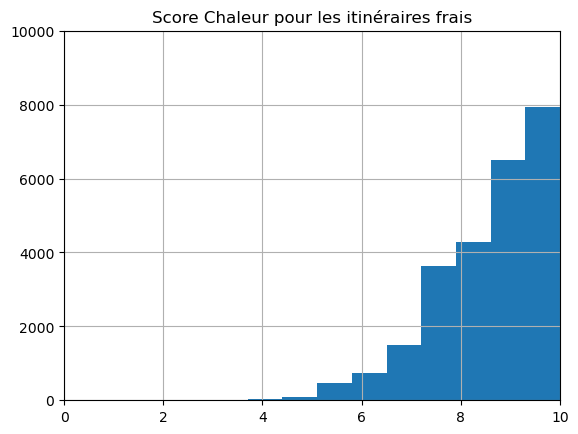

In [168]:
graph_P1O8At2Ar10C6E7Ca8_sample["score_10"].hist()
plt.xlim([0,10])
plt.ylim([0,10000])
plt.title("Score Chaleur pour les itinéraires frais")
plt.show()

In [172]:
data_set_P1O8At2Ar10C6E7Ca8_if = data_set_P1O8At2Ar10C6E7Ca8.loc[data_set_P1O8At2Ar10C6E7Ca8.index.unique().to_list()]
data_set_P1O8At2Ar10C6E7Ca8_if = data_set_P1O8At2Ar10C6E7Ca8_if[data_set_P1O8At2Ar10C6E7Ca8_if["type"] == "IF"]
print(data_set_P1O8At2Ar10C6E7Ca8_if.columns)

Index(['u', 'v', 'key', 'type', 'id_it', 'osmid', 'length', 'from', 'to',
       'total_score_08', 'total_score_13', 'total_score_18', 'freshness_score',
       'score_distance_08', 'score_distance_13', 'score_distance_18',
       'zone_id', 'geometry'],
      dtype='object')


In [173]:
data_set_P1O8At2Ar10C6E7Ca8_if["score_10"] = data_set_P1O8At2Ar10C6E7Ca8_if["total_score_13"].apply(lambda x: convert_score_on_ten(x, max_score_graph))

In [175]:
len(data_set_P1O8At2Ar10C6E7Ca8_if)

70900

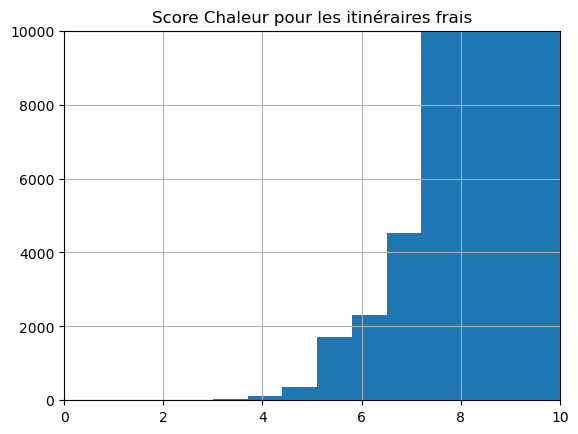

In [174]:
data_set_P1O8At2Ar10C6E7Ca8_if["score_10"].hist()
plt.xlim([0,10])
plt.ylim([0,10000])
plt.title("Score Chaleur pour les itinéraires frais")
plt.show()

#### Comparaison entre les distributions des scores (itinéraires)

In [147]:
max_score_if = np.max(it_if_P1O8At2Ar10C6E7Ca8["score"])
it_if_P1O8At2Ar10C6E7Ca8["score_10"] = it_if_P1O8At2Ar10C6E7Ca8["score"].apply(lambda x: convert_score_on_ten(x, max_score_if))

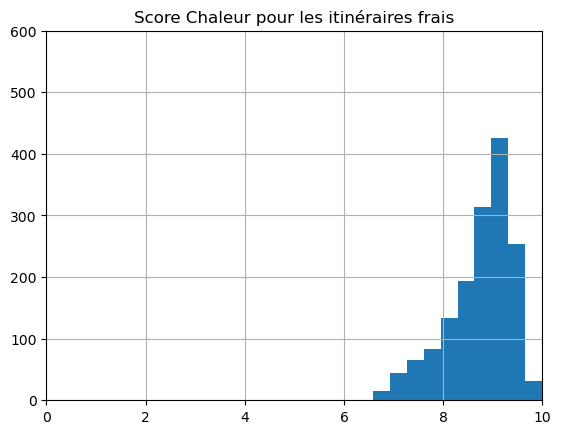

In [148]:
it_if_P1O8At2Ar10C6E7Ca8["score_10"].hist()
plt.xlim([0,10])
plt.ylim([0,600])
plt.title("Score Chaleur pour les itinéraires frais")
plt.show()

In [149]:
max_score_len = np.max(it_if_P1O8At2Ar10C6E7Ca8["score"])
it_len_P1O8At2Ar10C6E7Ca8["score_10"] = it_len_P1O8At2Ar10C6E7Ca8["score"].apply(lambda x: convert_score_on_ten(x, max_score_len))

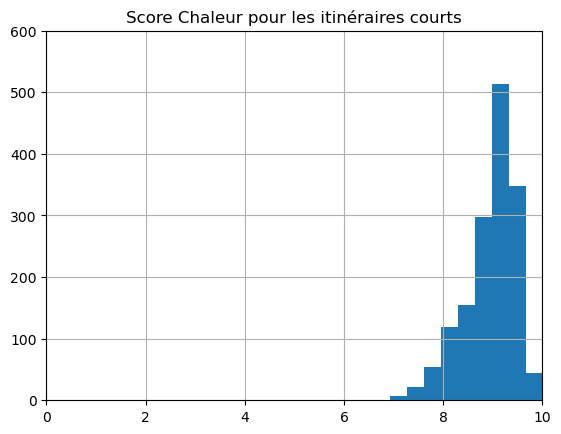

In [152]:
it_len_P1O8At2Ar10C6E7Ca8["score_10"].hist()
plt.xlim([0,10])
plt.ylim([0,600])
plt.title("Score Chaleur pour les itinéraires courts")
plt.show()

## Analyse P1O1At1Ar10C1E1Ca1
Praire : 1, Ombre : 1, Arbustes : 1, Arbres : 10, Température : 1, Eau : 1, Canopé : 1.

Les individus statistiques sont bien les itinéraires, que l'on va pouvoir comparer en fonction du traitement que l'on applique (pondération)
On va chercher à caractériser chacun des itinéraires en fonction de leur proportion en telle ou telle données

Un peu de stats : Dans le cas du test de Kolmogorov-Smirnov avec deux échantillons, on compare la distribution de deux échantillons (l'un théorique, dans notre cas, on prend la distirbution de l'itinéraire le plus court comme étant théorique). Il faut vérifier la p-value mais surtout le statistique de test. 
Attention, est-ce vraiment pertinent de regarder les distributions ? Pour moi il s'agit plutôt d'une comparaison de deux moyennes comme un test de student mais dans le cas de la plupart des données, les distributions ne sont pas normales.

Hypoothèse pour un test de student : 
* indépendances (sauf dans un cas avec données appariées, comme les notres) car dépendance de la distance
* échantillon aléatoire dans la population : OUI
* données dans chaque groupe distribué normalement : NON pour la plupart des données, sauf pour les arbres
* valeur des données continues : OUI
* variance pour les deux groupes indépenants égales : à vérifier, mais est-ce nécessaire dans le cas de groupe dépendants ? 
* Se pose la question de la taille des échantillons ..

In [6]:
data_set__prop_csv_P1O1At1Ar10C1E1Ca1 = pd.read_csv("./output_data/analyse/P1O1At1Ar10C1E1Ca1/mean_value_by_it_P1O1At1Ar10C1E1Ca1.csv")

In [7]:
data_set__prop_csv_P1O1At1Ar10C1E1Ca1.columns

Index(['id_it', 'type', 'mean_prairies_prop', 'mean_arbustes_prop',
       'mean_arbres_prop', 'mean_C_wavg_scaled', 'mean_eaux_prop',
       'mean_canop', 'mean_ombres_08_prop', 'mean_ombres_13_prop',
       'mean_ombres_18_prop', 'total_length', 'mean_score', 'score_10'],
      dtype='object')

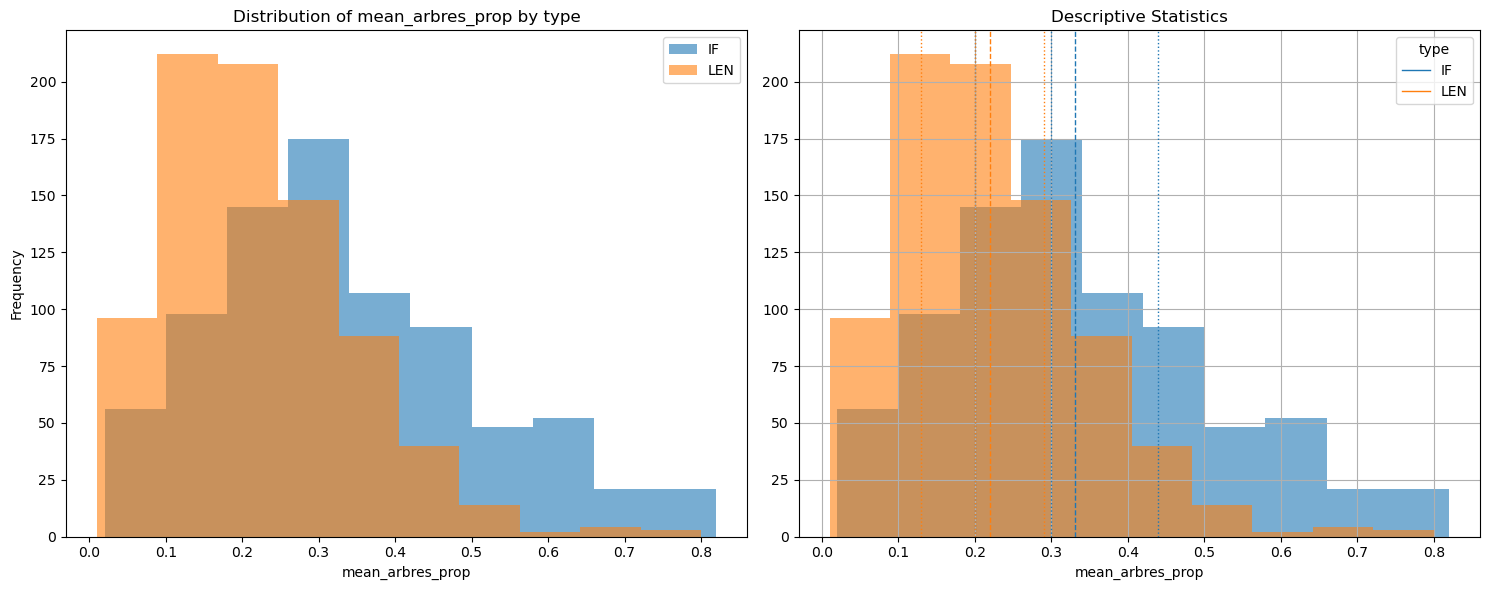

In [8]:
# Utilisation de la fonction pour le DataFrame "df" et les colonnes "mean_arbres_prop" et "type"
plot_distribution_by_category(data_set__prop_csv_P1O1At1Ar10C1E1Ca1, target_column='mean_arbres_prop', category_column='type')

Test de student avec données dépendantes. Individu stat avec traitement (pondération)

In [9]:
it_if_P1O1At1Ar10C1E1Ca1 = data_set__prop_csv_P1O1At1Ar10C1E1Ca1[data_set__prop_csv_P1O1At1Ar10C1E1Ca1["type"] == "IF"]
it_if_P1O1At1Ar10C1E1Ca1 = it_if_P1O1At1Ar10C1E1Ca1.set_index(["id_it"])
it_len_P1O1At1Ar10C1E1Ca1 = data_set__prop_csv_P1O1At1Ar10C1E1Ca1[data_set__prop_csv_P1O1At1Ar10C1E1Ca1["type"] == "LEN"]
it_len_P1O1At1Ar10C1E1Ca1 = it_len_P1O1At1Ar10C1E1Ca1.set_index(["id_it"])

In [31]:
mean_if = np.mean(it_if_P1O1At1Ar10C1E1Ca1["mean_arbres_prop"])
mean_len = np.mean(it_len_P1O1At1Ar10C1E1Ca1["mean_arbres_prop"])

sd_if = np.std(it_if_P1O1At1Ar10C1E1Ca1["mean_arbres_prop"])
sd_len = np.std(it_len_P1O1At1Ar10C1E1Ca1["mean_arbres_prop"])

print("mean if : ", mean_if)
print("sd if : ", sd_if)
print("mean len : ", mean_len)
print("sd len : ", sd_len)

mean if :  0.330478527607362
sd if :  0.17350629264673978
mean len :  0.22024539877300614
sd len :  0.12212610861404323


In [32]:
quantiles_if = np.quantile(it_if_P1O1At1Ar10C1E1Ca1["mean_arbres_prop"], q=[0.25,0.5,0.75])
quantiles_len = np.quantile(it_len_P1O1At1Ar10C1E1Ca1["mean_arbres_prop"], q=[0.25,0.5,0.75])

print("quantiles_if: ",quantiles_if)
print("quantiles_len: ", quantiles_len)

quantiles_if:  [0.2  0.3  0.44]
quantiles_len:  [0.13 0.2  0.29]


In [25]:
var_if = np.var(it_if_P1O1At1Ar10C1E1Ca1["mean_arbres_prop"])
var_len = np.var(it_len_P1O1At1Ar10C1E1Ca1["mean_arbres_prop"])
print("var_if : ", var_if)
print("var_len : ", var_len)
test_students(it_len_P1O1At1Ar10C1E1Ca1["mean_arbres_prop"], it_if_P1O1At1Ar10C1E1Ca1["mean_arbres_prop"])

var_if :  0.030104433588016108
var_len :  0.014914786405209084


TtestResult(statistic=-25.72087967448124, pvalue=3.008035990456993e-107, df=814)

In [23]:
ks_2samp_test(it_len_P1O1At1Ar10C1E1Ca1["mean_arbres_prop"], it_if_P1O1At1Ar10C1E1Ca1["mean_arbres_prop"], alternative="two-sided")

KS statistics :  0.29938650306748466
p-value :  1.2713803941483416e-32


(0.29938650306748466, 1.2713803941483416e-32)

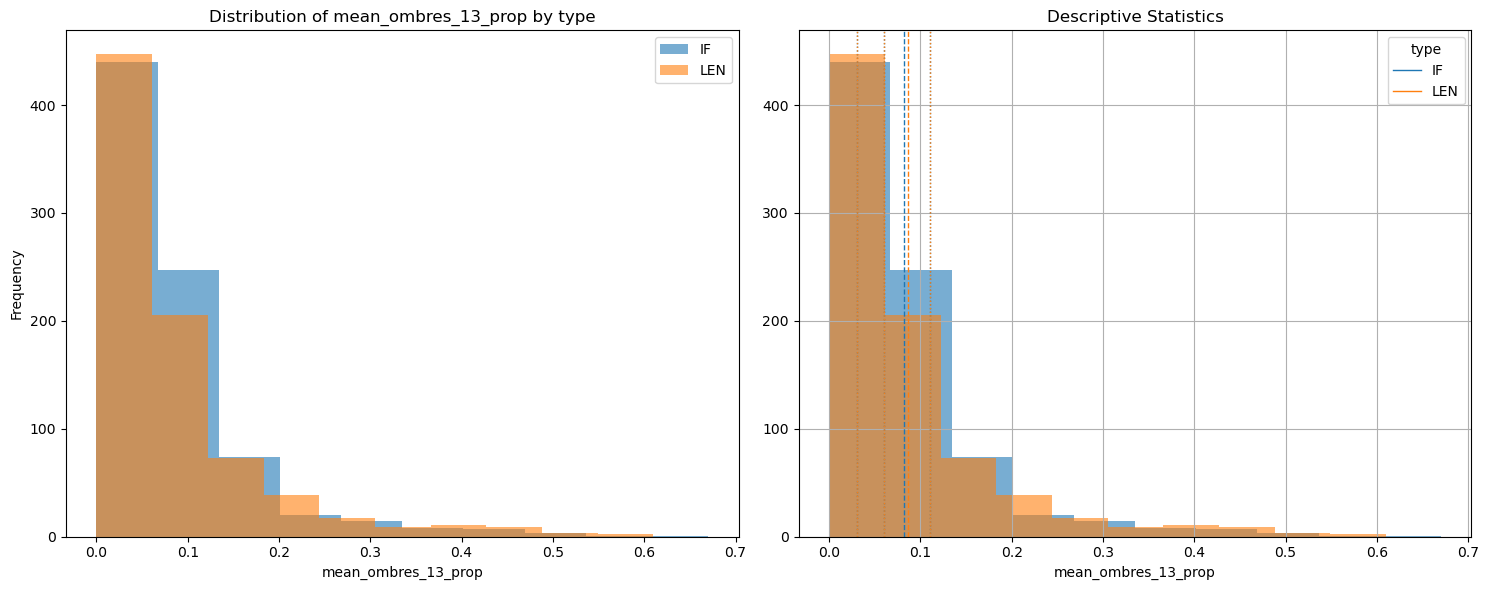

In [11]:
plot_distribution_by_category(data_set__prop_csv_P1O1At1Ar10C1E1Ca1, target_column='mean_ombres_13_prop', category_column='type')

In [21]:
ks_2samp_test(it_len_P1O1At1Ar10C1E1Ca1["mean_ombres_13_prop"], it_if_P1O1At1Ar10C1E1Ca1["mean_ombres_13_prop"], alternative="two-sided")

KS statistics :  0.03680981595092025
p-value :  0.6391627574813673


(0.03680981595092025, 0.6391627574813673)

H0 : les deux distributions sont égales, donc si p-value > 0.05, on ne peut pas rejetter H0, ce qui est le cas ici.

In [22]:
ks_2samp_test(it_len_P1O1At1Ar10C1E1Ca1["mean_prairies_prop"], it_if_P1O1At1Ar10C1E1Ca1["mean_prairies_prop"], alternative="two-sided")

KS statistics :  0.04785276073619632
p-value :  0.30839938137975775


(0.04785276073619632, 0.30839938137975775)

In [26]:
ks_2samp_test(it_len_P1O1At1Ar10C1E1Ca1["mean_arbustes_prop"], it_if_P1O1At1Ar10C1E1Ca1["mean_arbustes_prop"], alternative="two-sided")

KS statistics :  0.03558282208588957
p-value :  0.6809241316686812


(0.03558282208588957, 0.6809241316686812)

In [27]:
ks_2samp_test(it_len_P1O1At1Ar10C1E1Ca1["mean_C_wavg_scaled"], it_if_P1O1At1Ar10C1E1Ca1["mean_C_wavg_scaled"], alternative="two-sided")

KS statistics :  0.06134969325153374
p-value :  0.09306301726771331


(0.06134969325153374, 0.09306301726771331)

In [28]:
test_students(it_len_P1O1At1Ar10C1E1Ca1["mean_C_wavg_scaled"], it_if_P1O1At1Ar10C1E1Ca1["mean_C_wavg_scaled"])

TtestResult(statistic=9.508913630459755, pvalue=2.1060598846445236e-20, df=814)

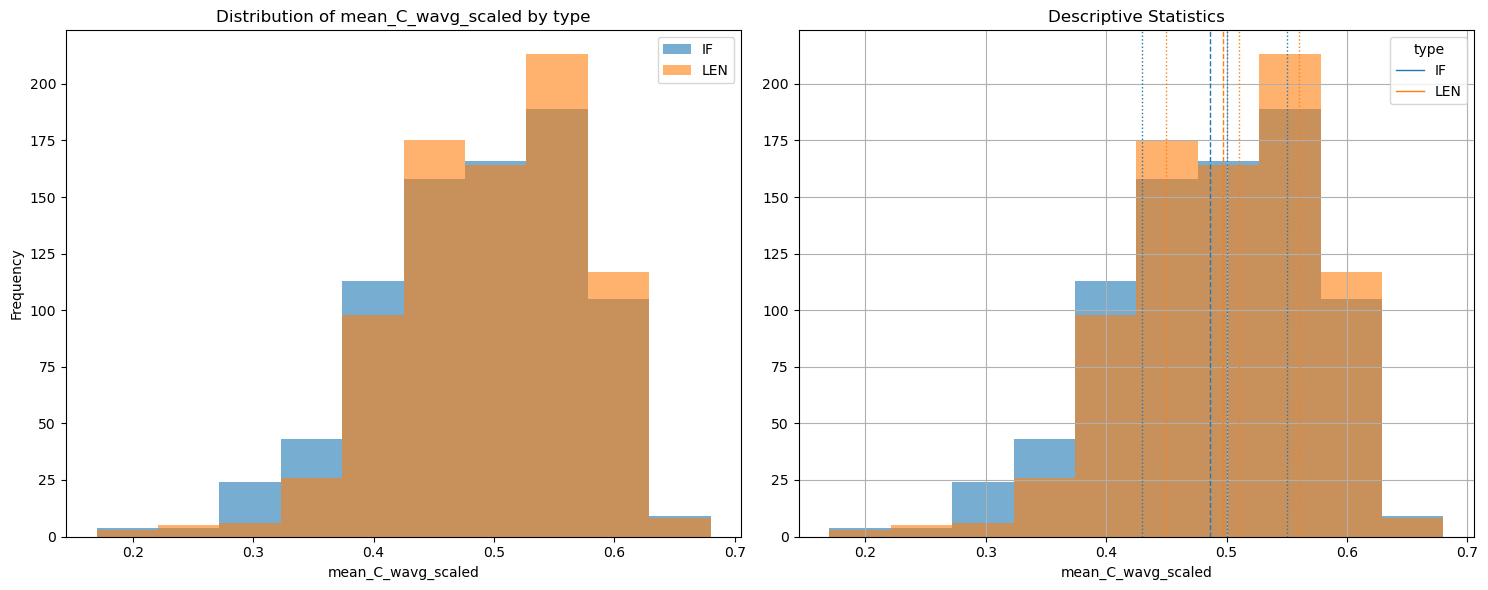

In [16]:
plot_distribution_by_category(data_set__prop_csv_P1O1At1Ar10C1E1Ca1, target_column='mean_C_wavg_scaled', category_column='type')

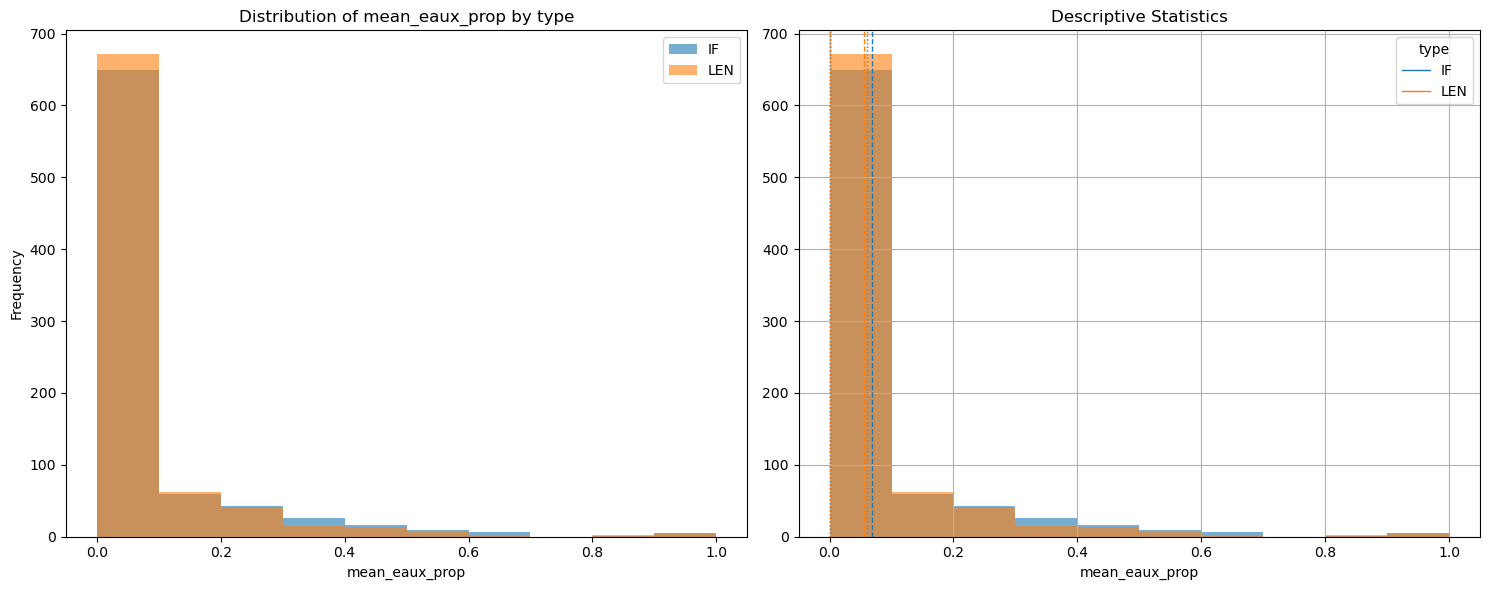

In [18]:
plot_distribution_by_category(data_set__prop_csv_P1O1At1Ar10C1E1Ca1, target_column='mean_eaux_prop', category_column='type')

In [29]:
ks_2samp_test(it_len_P1O1At1Ar10C1E1Ca1["mean_eaux_prop"], it_if_P1O1At1Ar10C1E1Ca1["mean_eaux_prop"], alternative="two-sided")

KS statistics :  0.04539877300613497
p-value :  0.37060604882127646


(0.04539877300613497, 0.37060604882127646)

In [30]:
print(distance_cost(it_len_P1O1At1Ar10C1E1Ca1, it_if_P1O1At1Ar10C1E1Ca1))

4.53


## Analyse P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01
Praire : 0.01, Ombre : 0.01, Arbustes : 0.01, Arbres : 10, Température : 0.01, Eau : 0.01, Canopé : 0.01.

In [33]:
data_set__prop_csv_P1O1At1Ar10C1E1Ca1 = pd.read_csv("./output_data/analyse/P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01/mean_value_by_it_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01.csv")

FileNotFoundError: [Errno 2] No such file or directory: './output_data/analyse/P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01/mean_value_by_it_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01.csv'